# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов мобильного оператора, которые пользуются двумя тарифами. Нужно найти общие паттерны поведения пользователей двух тарифов, чтобы обучить ML-модель рекомендовать пользователям тот или иной тариф. Предобработка данных не нужна, т.к. датасет уже очищен.

Цель задачи - построить модель с *accuracy* не меньше 0.75 на валидационной и тестовой выборках.

## Знакомство с датасетом

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
data = pd.read_csv('C:/Users/Xiaomi/Desktop/Oleg/Docs/Практикум/6 спринт Введение в ML/users_behavior.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
display(data.head(5))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


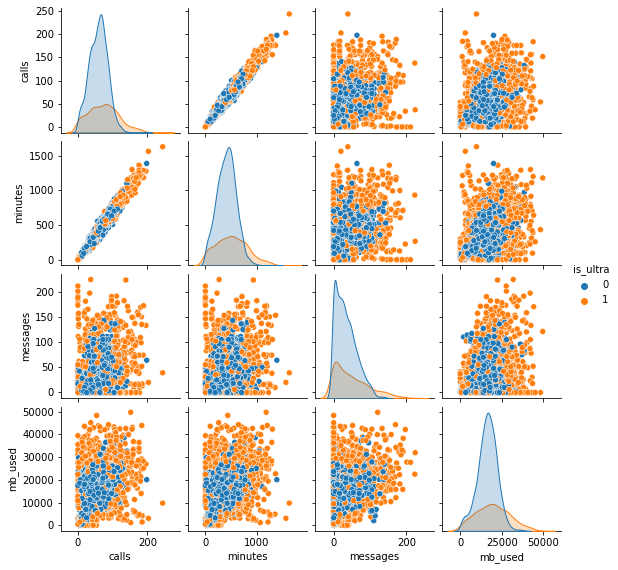

In [4]:
sns.pairplot(data, hue='is_ultra', height=2);

Из поверхностного анализа данных сложно делать однозначные выводы, т.к. поведенческие паттерны пользователей тарифа *ultra* имеют высокий разброс. Но определенно пользователи тарифа *ultra* говорят по телефону чаще и дольше, чем пользователи другого тарифа.

## Разбиение данных на выборки

In [5]:
#делим датасет на обучающую, валидационную и тестовую выборки в пропорциях 0.6 / 0.2 / 0.2
data_train, data_vt = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_vt, test_size=0.5, random_state=12345)

In [6]:
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']

features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

In [7]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


## Обучение моделей

### Решающее дерево

In [8]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0

for depth in range(1, 11):
    tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree_model.fit(features_train, target_train)
    predictions_tree_valid = tree_model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_tree_valid)
    if result > best_tree_result:
        best_tree_model = tree_model
        best_tree_result = result
        best_tree_depth = depth

print('Лучшее значение Accuracy:', best_tree_result)
print('Глубина лучшего дерева:', best_tree_depth)

Лучшее значение Accuracy: 0.7853810264385692
Глубина лучшего дерева: 3


### Случайный лес 

In [9]:
best_forest_model = None
best_forest_result = 0
best_est = 0
best_depth = 0

for depth in range(1, 11):
    for est in range(10, 51, 10):
        forest_model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        forest_model.fit(features_train, target_train)
        predictions_forest_valid = forest_model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_forest_valid)
        if result > best_forest_result:
            best_forest_result = result
            best_forest_model = forest_model
            best_est = est
            best_depth = depth

print('Лучшее значение Accuracy:', best_forest_result)
print('n_estimators =', best_est)
print('depth =', best_depth)

Лучшее значение Accuracy: 0.8087091757387247
n_estimators = 40
depth = 8


### Логистическая регрессия 

In [10]:
lr_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
lr_model.fit(features_train, target_train)
lr_predictions = lr_model.predict(features_valid)
lr_result = accuracy_score(target_valid, lr_predictions)
print('Accuracy:', lr_result)

Accuracy: 0.7107309486780715


На валидационной выборке лучший результат Accuracy 0.81 показала модель случайного леса с гиперпараметрами:
n_estimators = 40,\
depth = 8\
Худший результат у модели логистической регрессии - 0.71


## Проверка модели на тестовой выборке

In [11]:
print('Accuracy случайного леса на тестовой выборке:', accuracy_score(
    target_test, best_forest_model.predict(features_test)))

Accuracy случайного леса на тестовой выборке: 0.7962674961119751


На тестовой выборке случайный лес подтвердил высокое качество предсказания - *accuracy* значительно выше проходных 0.75. 

## Проверка модели на адекватность

In [12]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train, target_train)
dummy_predictions_valid = dummy_clf.predict(features_valid)
dummy_predictions_test = dummy_clf.predict(features_test)
print('Accuracy модели Dummy на валидационной выборке:',accuracy_score(target_valid, dummy_predictions_valid))
print('Accuracy модели Dummy на тестовой выборке:',accuracy_score(target_test, dummy_predictions_test))

Accuracy модели Dummy на валидационной выборке: 0.7060653188180405
Accuracy модели Dummy на тестовой выборке: 0.6842923794712286


In [13]:
data = [['DecisionTree', 0.79],
       ['RandomForest', 0.81],
       ['LogisticRegression', 0.71],
       ['Dummy', 0.71]]

columns = ['model', 'valid']
accuracy_table = pd.DataFrame(data=data, columns=columns)
display(accuracy_table)

,model,valid
0,DecisionTree,0.79
1,RandomForest,0.81
2,LogisticRegression,0.71
3,Dummy,0.71


В сравнении с бенчмарком - моделью Dummy, сделавшей предсказания на основании наиболее часто встречающегося значения, модели дерева решений и случайного леса демонстрируют значительно более высокое значение accuracy на валидационной выборке.
Для дальнейшей работы я бы выбрал модель случайного леса, т.к. ее показатели наиболее высокие.